# Proyek 2: Membuat Model ML dengan Data Time Series
---

Oleh: Mohammad Aditya Rafi Pratama (madityarafip - madityarafip31@gmail.com) - Depok, Indonesia

Pada proyek ini akan dirancang sebuah model Machine Learning untuk memprediksi konsumsi daya setiap jam menggunakan rangakaian data time series.
---

---

Proses pertama adalah import library yang digunakan

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout,Conv1D

import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split

from google.colab import files

Dengan memanfaatkan library yang tersedia pada Google Colab, dataset yang diperlukan akan diupload menggunakan fungsi upload.

In [ ]:
uploaded = files.upload()

Saving DOM_hourly.csv to DOM_hourly.csv


Setelah data berhasil diload, langkah selanjutnya adalah membaca file .csv dari dataset yang digunakan dengan menggunakan fungsi yang terdapat pada library pandas.

In [ ]:
d_ts = pd.read_csv('DOM_hourly.csv')
d_ts.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


Dapat dilihat pada tampilan data terdapat 2 kolom yang terbaca yaitu kolom Datetime dan DOM_MW yang menunjukkan pemakaian energi setiap jamnya. Selanjutnya kita akan melihat jumlah data dan apakah terdapat *missing value* di dalam dataset tersebut.

In [ ]:
d_ts.shape

(116189, 2)

In [ ]:
d_ts.isnull().sum()

Datetime    0
DOM_MW      0
dtype: int64

Karena dari pengecekan tidak terdapat *missing value* maka dapat dilanjutkan ke proses selanjutnya yaitu plot data. Pertama data waktu harus diubah menjadi format datetime, dan proses ini dapat dilakukan dengan menggunakan library 

```
pd.to_datetime(dataset)
```



In [ ]:
d_ts['Datetime']=pd.to_datetime(d_ts['Datetime'])
d_ts['Datetime'].head()

0   2005-12-31 01:00:00
1   2005-12-31 02:00:00
2   2005-12-31 03:00:00
3   2005-12-31 04:00:00
4   2005-12-31 05:00:00
Name: Datetime, dtype: datetime64[ns]

Karena pada plot data jam tidak dibutuhkan maka kolom Datetime akan diganti menjadi data tanggal dan menjadikannya index menggunakan library berikut

```
dataset.set_index()
```



In [ ]:
data_plot = d_ts[['Datetime','DOM_MW']].copy()
data_plot['date'] = data_plot['Datetime'].dt.date

data_plot=data_plot.drop('Datetime',axis=1)
data_plot.set_index('date', inplace= True)
data_plot.head()

,DOM_MW
date,
2005-12-31,9389.0
2005-12-31,9070.0
2005-12-31,9001.0
2005-12-31,9042.0
2005-12-31,9132.0


Dan sekarang masuk ke proses plot data konsumsi energi setiap jam.

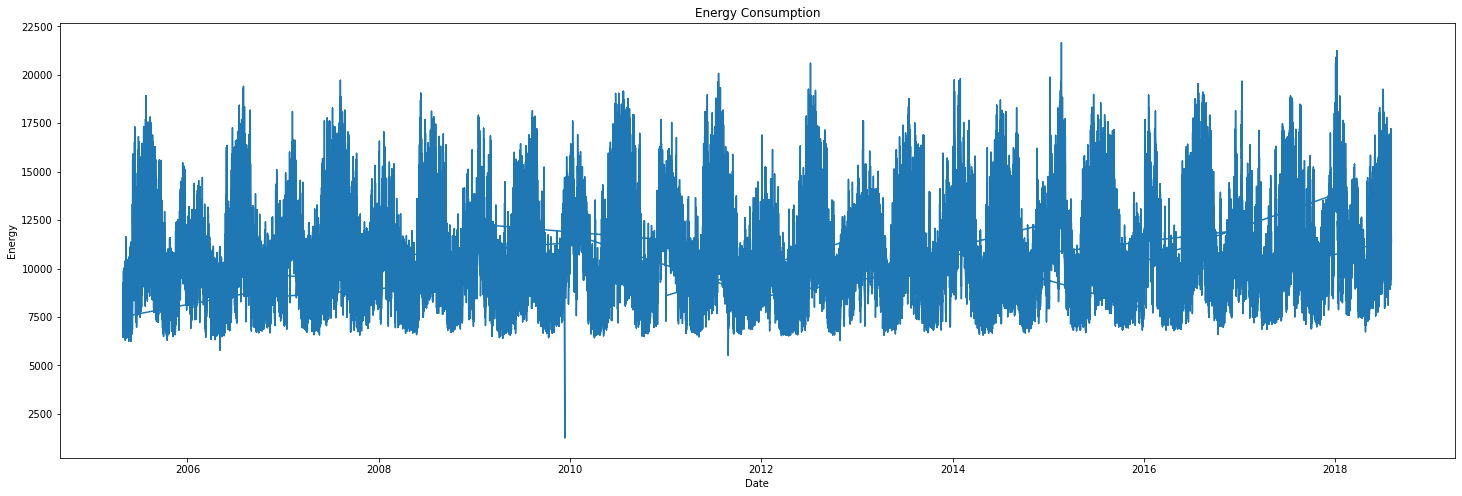

In [ ]:
plt.figure(figsize=(25, 8))
plt.plot(data_plot)
plt.title('Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy')
plt.show()

Proses selanjutnya adalah membagi data 
training dan data testing

In [ ]:
date_time = d_ts['Datetime']
temp = d_ts['DOM_MW']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(temp, date_time, test_size=0.2)
print('Train Data       : ', len(x_train))
print('Validation Data  : ', len(x_test))

Train Data       :  92951
Validation Data  :  23238


Fungsi berikut yang dapat merubah data menjadi format yang dapat diterima oleh model. Fungsi ini menerima sebuah series/atribut yang telah dikonversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
shuffle_buffer_size = 1000
window_size = 64
batch_size = 256
train = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val = windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)

Sebelum masuk proses melatih/training model dibutuhkan proses callback yang berfungi untuk memberhentikan proses pelatihan ketika mencapai akurasi yang ditentukan, yang dimana pada proyek ini akan berhenti ketika mencapai MAE < 10% skala data.

In [ ]:
class MeineCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < mae_min  and logs.get('val_mae') < mae_min):
            self.model.stop_training = True
            print("Training complete! Reached < 10% of data scale")

callback = MeineCallback()

10% dari skala data didapatkan dengan menggunakan program berikut.

In [ ]:
ener_max = temp.max()
ener_min = temp.min()
limit_percentage_of_data = 10/100

mae_min = (ener_max - ener_min) * limit_percentage_of_data
print('10% from data = ', mae_min)

10% from data =  2039.8000000000002


Selanjutnya untuk arsitektur model gunakan 2 buah layer Biderectional-LSTM. Ketika menggunakan 2 buah layer LSTM, perhatikan bahwa layer pertama harus memiliki parameter return_sequences yang bernilai True.

In [ ]:
model = tf.keras.models.Sequential([
                    Conv1D(filters=60, kernel_size=5,
                           strides=1, padding='causal',
                           activation='relu', input_shape=[None, 1]),
                    Bidirectional(LSTM(60, return_sequences=True)),
                    Bidirectional(LSTM(60)),
                    Dense(30, activation="relu"),
                    Dense(10, activation="relu"),
                    Dense(1)
                  ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 120)         58080     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120)               86880     
_________________________________________________________________
dense_15 (Dense)             (None, 30)                3630      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 149,271
Trainable params: 149,271
Non-trainable params: 0
________________________________________________

Proses selanjutnya adalah melatih model dengan menggunakan fungsi fit(). Pada proses ini juga akan dimasukkan nilai Epoch yang diinginkan dengan fungsi

```
input()
```
Selain itu, pada proses ini digunakan juga optimizer dengan ditambah *Learning Rate* dan *Momentum* sebagai hyperparameter dari proses pelatihan.


In [ ]:
num_epochs = int(input('Epoch = '))
print(' ')
optimizer = tf.keras.optimizers.SGD(lr=1.2500e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train,
                    epochs=num_epochs,
                    callbacks=[callback], 
                    validation_data=val, 
                    verbose=1
                    )

Epoch = 100
 
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


363/363 [==============================] - 26s 59ms/step - loss: 10945.1221 - mae: 10945.6221 - val_loss: 10962.0225 - val_mae: 10962.5225
Epoch 2/100
363/363 [==============================] - 18s 49ms/step - loss: 10944.8506 - mae: 10945.3506 - val_loss: 10961.7607 - val_mae: 10962.2607
Epoch 3/100
363/363 [==============================] - 18s 50ms/step - loss: 10944.5371 - mae: 10945.0371 - val_loss: 10961.3877 - val_mae: 10961.8877
Epoch 4/100
363/363 [==============================] - 18s 50ms/step - loss: 10944.0674 - mae: 10944.5674 - val_loss: 10960.8027 - val_mae: 10961.3027
Epoch 5/100
363/363 [==============================] - 18s 49ms/step - loss: 10943.2832 - mae: 10943.7832 - val_loss: 10959.7568 - val_mae: 10960.2568
Epoch 6/100
363/363 [==============================] - 18s 50ms/step - loss: 10941.7812 - mae: 10942.2812 - val_loss: 10957.6074 - val_mae: 10958.1064
Epoch 7/100
363/363 [==============================] - 18s 49ms/step - loss: 10938.1992 - mae: 10938.6992 

Setelah proses training selesai, proses selanjutnya adalah melihat apakah nilai MAE dari *train* dan *validation* sudah memenuhi kriteria < 10% sampel data.

In [ ]:
last_mae_train = history.history['mae'][-1]
last_mae_val = history.history['val_mae'][-1]

In [ ]:
percentage_mae_result = last_mae_train / (ener_max - ener_min)
percentage_mae_result = percentage_mae_result*100
print('MAE training   = ', percentage_mae_result, '%')

MAE training   =  9.254320467999314 %


In [ ]:
percentage_val_mae_result = last_mae_val / (ener_max - ener_min)
percentage_val_mae_result = percentage_val_mae_result*100
print('MAE validation = ', percentage_val_mae_result, '%')

MAE validation =  9.215328943286414 %


Selanjutnya adalah proses plot nilai loss dan MAE pada epoch yang berjalan

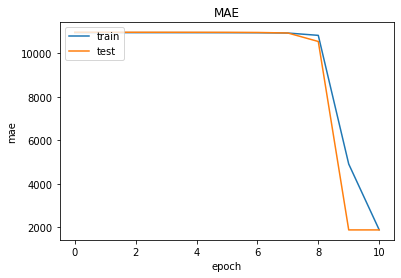

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

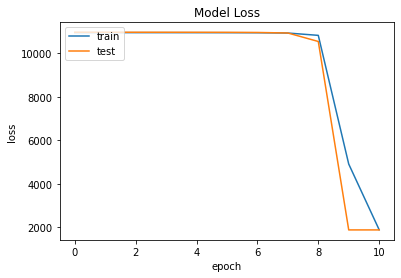

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()